In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import pickle
import myUtils
import os
import csv
import random
import matplotlib.pyplot as plt
from myUtils import *
from models.utils import *
from APOC import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# can be sentiment/offensive/corona
dataset_name = 'corona'
model_type = 'tinybert'
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
sorting = 'confidence'
delta = '0.1'
folder_name = f'results/{dataset_name}/{sorting}/{delta}'

In [3]:
# when apply torchscript to models sometimes
torch._C._jit_set_texpr_fuser_enabled(False)

In [4]:
model = torch.jit.load(f'models/{model_type}/{dataset_name}/traced.pt').to(device)
model = model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
myUtils.model = model
myUtils.tokenizer = tokenizer

# Loading Results

In [5]:
explanations  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
explanations.sort(key = lambda x: x.index)
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))

In [10]:
#pickle.dump(explanations, open(f"{folder_name}/exps_list.pickle", "wb"))

In [11]:
print(f'anchor examples len: {len(anchor_examples)}')
print(f'explanations len: {len(explanations)}')

anchor examples len: 3744
explanations len: 72184


In [6]:
if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([tokenizer.tokenize(anchor_example)])[0] for anchor_example in anchor_examples]
    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

In [7]:
def get_scores_dict(top=25, trail_path = "0.1/scores.xlsx", alpha = 0.95):
    """
    returns dict of (anchor, score) pairs, and sum of the topk positive/negative
    """
    
    df = pd.read_excel(f'{folder_name}/{trail_path}').drop(0)
    
    index_prefix = f"{alpha}-" if alpha is not None else ""
    
    neg_keys = df[f'{index_prefix}negative'].dropna().tolist()
    neg_values = df.iloc[:, list(df.columns).index(f'{index_prefix}negative')+1].tolist()
    neg_scores =dict(zip(neg_keys, neg_values))    

    pos_keys = df[f'{index_prefix}positive'].dropna().tolist()
    pos_values = df.iloc[:, list(df.columns).index(f'{index_prefix}positive')+1].tolist()
    pos_scores = dict(zip(pos_keys, pos_values))
    
    return pos_scores, neg_scores

# Scores Utils

In [10]:
from functools import reduce
# get all anchor above 0.95, multiple in a sentence but word counts only once in a sentence
def get_best(explanations):
    best_exps = dict()
    for exp in explanations:
        if exp.precision < 0.95:
            continue
        if exp.index not in best_exps.keys():
            best_exps[exp.index]=[exp]
        # if word already appeard in sentence
        #elif any([cur_exp.names[0]==exp.names[0] for cur_exp in best_exps[exp.index]]):
        #    continue
        else:
            best_exps[exp.index].append(exp)
    print(len(best_exps))
    return reduce(lambda x,y: x+y, best_exps.values())

In [11]:
from collections import Counter

def get_anchor_occurences(explanations):
    c = Counter()
    for exp in explanations:
        c.update([exp.names[0]])
 
    return c

def get_normal_occurences(sentences, anchor_occurences):
    c = Counter()
    for sentence in sentences:
        c.update(tokenizer.tokenize(sentence))
   
    #removing occurences of the words as anchor
    for word in anchor_occurences.keys():
        c[word]-=anchor_occurences[word]
        
    return c

def smooth_before(normal_occurences, anchor_occurences_list):
    for w in normal_occurences:
        normal_occurences[w]+=1
        for anchor_occurences in anchor_occurences_list:
            anchor_occurences[w]+=1

def smooth_after(teta1, type_occurences):
    # removing words we added 1 at the start smooth
    words = list(teta1.keys())
    for word in words:
        if type_occurences[word]<=1:
            del teta1[word]
            
    min_val = min(teta1.values()) 
    if min_val<0:
        for w in teta1:
            teta1[w]-= min_val
        sum_val = sum(teta1.values())
        for w in teta1:
            teta1[w]= teta1[w]/sum_val

In [12]:
def calculate_teta0(normal_occurences):
    teta0 = dict()
    sum_occurences = sum(normal_occurences.values())
    for word, count in normal_occurences.items():
        teta0[word] = count/sum_occurences
    
    return teta0

def calculate_teta1(anchor_occurences, teta0, alpha):
    teta1 = dict()
    sum_occurences = sum(anchor_occurences.values())
    for word, count in anchor_occurences.items():
        teta1[word] = count/sum_occurences -(1-alpha)*teta0[word]
        teta1[word] = teta1[word]/alpha
    
    return teta1

In [13]:
def calculate_scores(explanations, percent):
    alphas = [0.95, 0.8, 0.65, 0.5]
    dfs = []
    columns = ['name', 'anchor score', 'type occurences', 'total occurences','+%', '-%', 'both', 'normal']
    
    exps = get_best(explanations)
    pos_exps = [exp for exp in exps if labels[exp.index]==0]
    neg_exps = [exp for exp in exps if labels[exp.index]==1]
    
    anchor_occurences = get_anchor_occurences(exps)
    pos_occurences = get_anchor_occurences(pos_exps)
    neg_occurences = get_anchor_occurences(neg_exps)
    
    normal_occurences = get_normal_occurences(anchor_examples, anchor_occurences)
    smooth_before(normal_occurences, [pos_occurences, neg_occurences])

    teta0 = calculate_teta0(normal_occurences)
    
    
    for alpha in alphas:
        df_pos, df_neg = [], []
        
        teta_pos = calculate_teta1(pos_occurences, teta0, alpha)
        smooth_after(teta_pos, pos_occurences)
        
        teta_neg = calculate_teta1(neg_occurences, teta0, alpha)
        smooth_after(teta_neg, neg_occurences)
        
        # substracting 1 because of the smoothing
        for anchor, score in teta_pos.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_pos.append([anchor, score , pos_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        
        for anchor, score in teta_neg.items():
            pos_percent = round((pos_occurences[anchor]-1)/anchor_occurences[anchor], 2)
            neg_percent = 1-pos_percent
            both = (pos_occurences[anchor]-1)>0 and (neg_occurences[anchor]-1)>0
            df_neg.append([anchor, score , neg_occurences[anchor]-1, anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]-1]) 
            
        df_pos.sort(key=lambda exp: -exp[1])
        df_neg.sort(key=lambda exp: -exp[1])
        df_pos = pd.DataFrame(data = df_pos, columns = columns ).set_index('name')
        df_neg = pd.DataFrame(data = df_neg, columns = columns ).set_index('name')
        
        dfs.extend([df_pos, df_neg])
        
    writer = pd.ExcelWriter(f'{folder_name}/time/scores-{percent}.xlsx', engine='xlsxwriter') 
    
    workbook=writer.book
    worksheet=workbook.add_worksheet('Sheet1')
    writer.sheets['Sheet1'] = worksheet
    
    cur_col = 0
    is_positive = False
    alphas = np.repeat(alphas, 2)
    
    for df, alpha in zip(dfs, alphas):
        cur_type = 'positive' if is_positive else 'negative'
        is_positive = not is_positive
        worksheet.write(0, cur_col, f'{alpha}-{cur_type}')
        df.to_excel(writer, sheet_name=f'Sheet1', startrow=1, startcol=cur_col)
        cur_col+= len(columns) + 1

    writer.save()

# calculation

In [15]:
num_exps = len(explanations)
for i in [25, 50, 75]:
    index = int((i*num_exps/100))
    exps = explanations[:index]
    calculate_scores(exps, i)

836
1421
1772


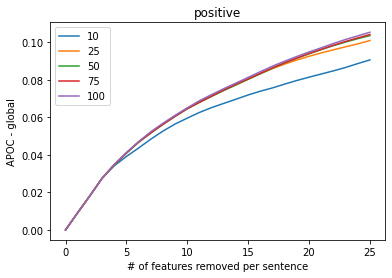

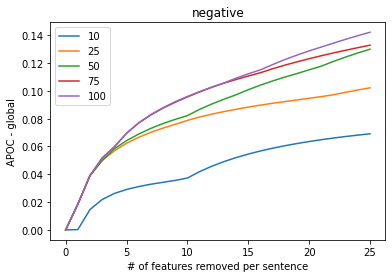

In [16]:
pos_tokens_arr = []
neg_tokens_arr = []
percents = [10, 25, 50, 75, 100]
for percent in percents:
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../0.1/time/scores-{percent}.xlsx", alpha = 0.95)
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)

APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, percents)